## This notebook walks through processing WQP data using the harmonize-wq package


##### import the required libraries. Check requirements.txt for dependencies that should be installed.

In [1]:
import os
import pandas
import geopandas
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
import dataretrieval.wqp as wqp

#### Download location data using dataretrieval

In [2]:
os.getcwd()

'L:\\Public\\jbousqui\\Code\\GitHub\\HWBI_update\\ESI\\harmonize-wq'

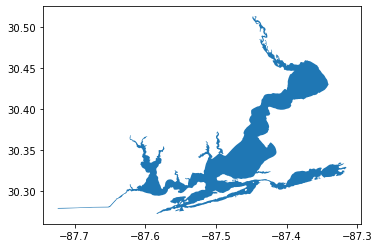

In [3]:
# Read geometry for Area of Interest from test data or local file
#aoi_url = r'https://github.com/USEPA/HWBI_update/raw/master/ESI/harmonize-wq/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_url = os.path.join(os.getcwd(), r'harmonize_wq\tests\data\PPBays_NCCA.geojson')  #Local file
aoi_gdf = geopandas.read_file(aoi_url)

# Map aoi
aoi_gdf.plot()

In [4]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf

,FID,EDACDA_NM,geometry
0,1,Perdido Bay,"POLYGON ((-87.44272 30.51169, -87.44280 30.512..."


In [5]:
# Spatial query parameters (Note: first poly only)
bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [6]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [7]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [8]:
# Rows and columns for results
stations.shape

(531, 36)

In [9]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,CountyCode,AquiferName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107,27.80,sq mi,27.80,...,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-AL,USGS Alabama Water Science Center,USGS-02377960,"BLACKWATER RIVER AT CO RD 87 NEAR ELSANOR, AL.",Stream,NaN,3140106,56.60,sq mi,56.60,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-AL,USGS Alabama Water Science Center,USGS-02377975,BLACKWATER RIVER ABOVE SEMINOLE AL,Stream,NaN,3140106,40.20,sq mi,NaN,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-AL,USGS Alabama Water Science Center,USGS-02378150,"SANDY CREEK AT US HWY 98 NEAR ELBERTA, AL.",Stream,NaN,3140107,5.70,sq mi,5.70,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-AL,USGS Alabama Water Science Center,USGS-02378170,"WOLF CREEK BELOW FOLEY, ALA",Stream,NaN,3140107,4.98,sq mi,4.98,...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [10]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName      NAD83
LatitudeMeasure                                 30.4983
LongitudeMeasure                               -87.3358
Name: 0, dtype: object

In [11]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = harmonize.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [12]:
harmonize.harmonize_locations?

In [13]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(531, 41)

In [14]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig                (-87.3358086, 30.49825159)
EPSG                                           4269
QA_flag                                         NaN
geom         POINT (-87.33580859999999 30.49825159)
geometry     POINT (-87.33580859999999 30.49825159)
Name: 0, dtype: object

In [15]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [16]:
# Look at QA_flag for one w/ bad datum
stations_gdf.loc[stations_gdf['QA_flag'].notna()].iloc[0]['QA_flag']

'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'

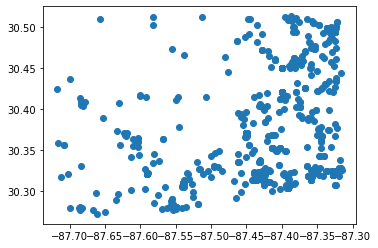

In [17]:
stations_gdf.plot()

In [18]:
# Clip to area of interest
aoi_gdf.to_crs(4326, inplace=True)
stations_clipped = geopandas.clip(stations_gdf, aoi_gdf)

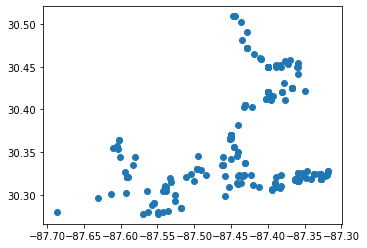

In [19]:
# Map it
stations_clipped.plot()

In [20]:
# How many stations now?
len(stations_clipped)

220

In [21]:
# To save the results to a shapefile
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [22]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\ArcGIS\Local_GIS\Python\envs\arc-py3-osgeo\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (10,19,23,31,60,69,70,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [23]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1533025F1,2013-09-03,09:01:00,EST,21FLPNS_WQX-33010H24,STORET-308200310,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1534026F1,2013-09-08,10:01:00,EST,21FLBFA_WQX-33020M31,STORET-272693106,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1502139F1-19151,2013-05-05,15:55:00,EST,21FLBFA_WQX-33010092,STORET-747267008,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1497856F1,2013-04-16,08:01:00,EST,21FLPNS_WQX-330100A7,STORET-308209380,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-195719_1074008_173,2013-08-19,11:00:00,CST,21AWIC-7290,STORET-290894183,1074008.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60623,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113232_629452_173,1980-12-10,10:35:00,CST,21AWIC-942,STORET-175988174,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
60624,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113212_629390_173,1980-02-20,12:00:00,CST,21AWIC-942,STORET-175987603,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
60625,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113210_629386_173,1980-01-23,10:55:00,CST,21AWIC-942,STORET-175987555,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
60626,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113224_629429_173,1980-08-06,10:00:00,CST,21AWIC-942,STORET-175987899,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


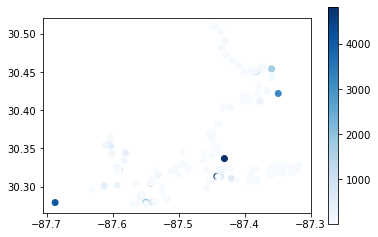

In [24]:
# Map counts of all results
results_cnt = df.groupby('MonitoringLocationIdentifier').size().to_frame('cnt')
results_cnt.reset_index(inplace=True)

# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry', 'QA_flag']
results_df = wrangle.merge_tables(results_cnt, stations_clipped, gdf_cols, merge_cols)
cnt_gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')

# Map it
cnt_gdf.plot(column='cnt', cmap='Blues', legend=True)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [25]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize_generic?

##### secchi disk depth

-Usable results-
count    2468.000000
mean        1.268498
std         5.259185
min         0.000000
25%         0.700000
50%         1.000000
75%         1.500000
max       260.000000
dtype: float64
Unusable results: 3
Usable results with inferred units: 0
Results outside threshold (0.0 to 32.82360648682461): 1


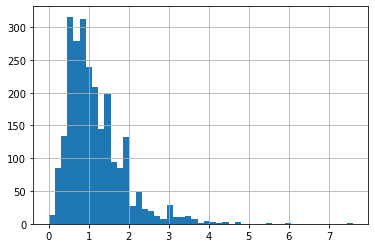

In [26]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [27]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
9,1.25,m,NaN,m,1.25 meter
52,0.75,m,NaN,m,0.75 meter
83,1.16,m,NaN,m,1.16 meter
84,2.25,m,NaN,m,2.25 meter
86,1.50,m,NaN,m,1.5 meter
...,...,...,...,...,...
60487,1.74,m,NaN,m,1.74 meter
60495,1.23,m,NaN,m,1.23 meter
60515,1.38,m,NaN,m,1.38 meter
60522,.8,m,NaN,m,0.8 meter


In [28]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
51113,*Not Reported,m,"ResultMeasureValue: ""*Not Reported"" result can...",m,NaN
59265,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
59414,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [29]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "*Not Reported" result cannot be used'

In [30]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
51113,*Not Reported,m,"ResultMeasureValue: ""*Not Reported"" result can...",m,NaN
59265,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
59414,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


All these were missing both a value and unit so nothing could be done

In [31]:
# Aggregate Secchi data by station to look at results spatially
cols = ['MonitoringLocationIdentifier','Secchi']
secchi_df = df.loc[df['Secchi'].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in secchi_df['Secchi']]
secchi_df['secchi_magnitude'] = pandas.Series(avg, index=secchi_df['Secchi'].index) 
secchi_df_agg = secchi_df.groupby('MonitoringLocationIdentifier').size().to_frame('cnt')
cols = ['MonitoringLocationIdentifier', 'secchi_magnitude']
secchi_df_agg['mean'] = secchi_df[cols].groupby('MonitoringLocationIdentifier').mean()
secchi_df_agg.reset_index(inplace=True)
secchi_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT01,12,2.333333
1,11NPSWRD_WQX-GUIS_CMP_PKT02,17,2.411765
2,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
3,21AWIC-1063,116,0.767931
4,21AWIC-1122,56,2.790786
...,...,...,...
193,"NALMS-C30.36417,-87.60263",15,0.590000
194,"NALMS-C30.36742,-87.62082",16,0.768750
195,"NALMS-C30.36791,-87.62195",29,0.929310
196,"NALMS-C30.401,-87.426",2,0.950000


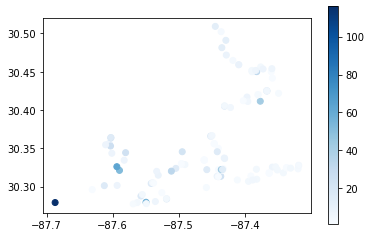

In [32]:
# Map Secchi by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
secchi_df_agg = wrangle.merge_tables(secchi_df_agg, stations_clipped, gdf_cols, merge_cols)
secchi_gdf = geopandas.GeoDataFrame(secchi_df_agg, geometry='geometry')

# Map Counts
secchi_gdf.plot(column='cnt', cmap='Blues', legend=True)

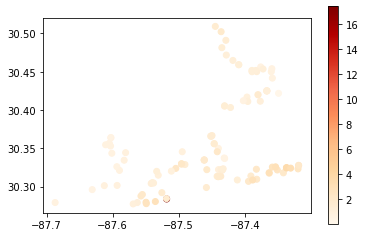

In [33]:
# Map Averages
secchi_gdf.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    10298.000000
mean        23.055925
std          5.882393
min          1.000000
25%         18.822500
50%         23.888889
75%         28.100000
max         41.300000
dtype: float64
Unusable results: 1
Usable results with inferred units: 0
Results outside threshold (0.0 to 58.35028550916063): 0


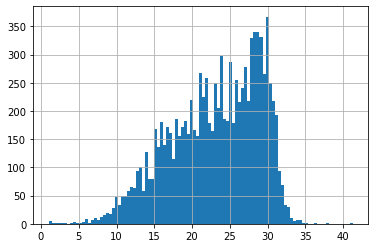

In [34]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [35]:
# Look at what was changed
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
1,29.56,deg C,NaN,29.56 degree_Celsius,degC
5,23.56,deg C,NaN,23.56 degree_Celsius,degC
16,26.02,deg C,NaN,26.02 degree_Celsius,degC
20,29.3,deg C,NaN,29.3 degree_Celsius,degC
21,22.5,deg C,NaN,22.5 degree_Celsius,degC
...,...,...,...,...,...
60610,23,deg C,NaN,23.0 degree_Celsius,degC
60611,25,deg C,NaN,25.0 degree_Celsius,degC
60615,17,deg C,NaN,17.0 degree_Celsius,degC
60617,16,deg C,NaN,16.0 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [36]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
29350,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [37]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [38]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
29350,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [39]:
# Aggregate temperature data by station
cols = ['MonitoringLocationIdentifier','Temperature']
temp_df = df.loc[df[cols[1]].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in temp_df[cols[1]]]
temp_df['Temperature_magnitude'] = pandas.Series(avg, index=temp_df[cols[1]].index) 
temp_df_agg = temp_df.groupby(cols[0]).size().to_frame('cnt')
cols += ['Temperature_magnitude']
temp_df_agg['mean'] = temp_df[cols].groupby(cols[0]).mean()
temp_df_agg.reset_index(inplace=True)
temp_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,24.986667
1,11NPSWRD_WQX-GUIS_CMP_PKT01,20,25.125000
2,11NPSWRD_WQX-GUIS_CMP_PKT02,20,25.600000
3,11NPSWRD_WQX-GUIS_CMP_PKT03,2,30.250000
4,11NPSWRD_WQX-GUIS_GCR_PK1_1,1,23.900000
...,...,...,...
397,USGS-303720087400501,1,21.000000
398,USGS-303800087304501,1,21.000000
399,USGS-303845087401501,1,22.000000
400,USGS-303920087304501,1,21.000000


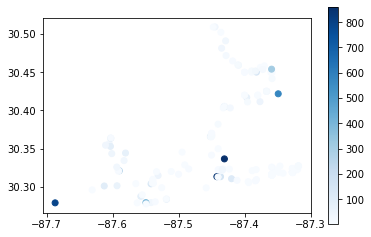

In [40]:
# Map Temperature by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
temperature_df_agg = wrangle.merge_tables(temp_df_agg, stations_clipped, gdf_cols, merge_cols)
temp_gdf = geopandas.GeoDataFrame(temperature_df_agg, geometry='geometry')
# Map Counts
temp_gdf.plot(column='cnt', cmap='Blues', legend=True)

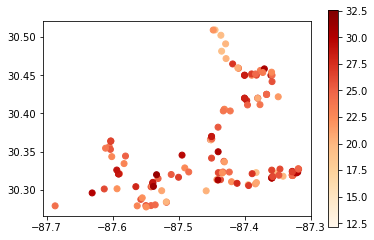

In [41]:
# Map Averages
temp_gdf.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [42]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [43]:
# Look at what was changed
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,5.07,mg/l,NaN,5.07 milligram / liter
2,7.48,mg/l,NaN,7.48 milligram / liter
11,6.05,mg/l,NaN,6.05 milligram / liter
13,0.34,mg/l,NaN,0.34 milligram / liter
17,6.23,mg/l,NaN,6.23 milligram / liter
...,...,...,...,...
60582,8.9,mg/l,NaN,8.9 milligram / liter
60602,7.9,mg/l,NaN,7.9 milligram / liter
60614,6.1,mg/l,NaN,6.1 milligram / liter
60623,7.1,mg/l,NaN,7.1 milligram / liter


In [44]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
378,5,ppm,NaN,4.131166209e-05 milligram / liter
738,6,ppm,NaN,4.9573994508e-05 milligram / liter
1416,5,ppm,NaN,4.131166209e-05 milligram / liter
1856,8,ppm,NaN,6.6098659344e-05 milligram / liter
2525,6,ppm,NaN,4.9573994508e-05 milligram / liter
3753,11,ppm,NaN,9.088565659799999e-05 milligram / liter
5529,7,ppm,NaN,5.7836326926e-05 milligram / liter
7647,7,ppm,NaN,5.7836326926e-05 milligram / liter
9096,9,ppm,NaN,7.4360991762e-05 milligram / liter
9808,7,ppm,NaN,5.7836326926e-05 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [45]:
# Aggregate DO data by station
cols = ['MonitoringLocationIdentifier','DO']
do_df = df.loc[df[cols[1]].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in do_df[cols[1]]]
do_df['DO_magnitude'] = pandas.Series(avg, index=do_df[cols[1]].index) 
do_df_agg = do_df.groupby(cols[0]).size().to_frame('cnt')
cols += ['DO_magnitude']
do_df_agg['mean'] = do_df[cols].groupby(cols[0]).mean()
do_df_agg.reset_index(inplace=True)
do_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_ADEM_ALPT,30,6.698000
1,11NPSWRD_WQX-GUIS_GCRL_PND05,2,8.900000
2,11NPSWRD_WQX-GUIS_GCRL_PND06,4,10.150000
3,11NPSWRD_WQX-GUIS_GCR_PK1_1,1,5.730000
4,11NPSWRD_WQX-GUIS_GCR_PK1_3,1,4.550000
...,...,...,...
264,"NALMS-C30.3408,-87.6127",1,0.000041
265,"NALMS-C30.36353,-87.56797",2,0.000045
266,"NALMS-C30.36742,-87.62082",2,0.000326
267,"NALMS-C30.36791,-87.62195",14,0.000055


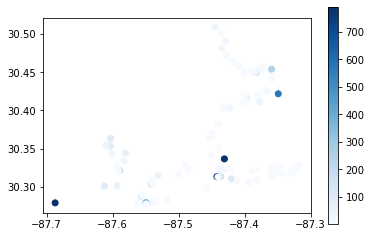

In [46]:
# Map DO by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
do_df_agg = wrangle.merge_tables(do_df_agg, stations_clipped, gdf_cols, merge_cols)
do_gdf = geopandas.GeoDataFrame(do_df_agg, geometry='geometry')
# Map Counts
do_gdf.plot(column='cnt', cmap='Blues', legend=True)

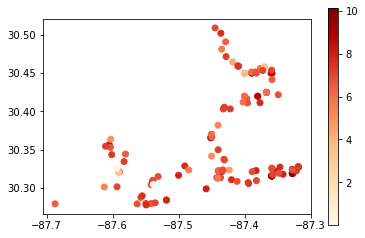

In [47]:
# Map Averages
do_gdf.plot(column='mean', cmap='OrRd', legend=True)

###### pH

-Usable results-
count    9794.000000
mean        7.199993
std         0.947070
min         3.090000
25%         6.710000
50%         7.470000
75%         7.900000
max        12.280000
dtype: float64
Unusable results: 14
Usable results with inferred units: 7
Results outside threshold (0.0 to 12.882416085605776): 0


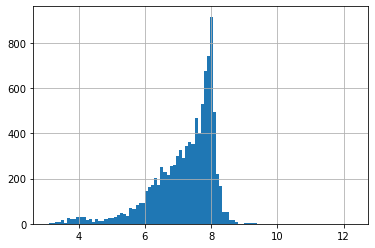

In [48]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [49]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
3,6.93,None,NaN,6.93 dimensionless
15,8.09,None,NaN,8.09 dimensionless
19,7.26,None,NaN,7.26 dimensionless
23,7.72,None,NaN,7.72 dimensionless
30,8.02,None,NaN,8.02 dimensionless
...,...,...,...,...
60609,6.3,None,NaN,6.3 dimensionless
60613,5.8,None,NaN,5.8 dimensionless
60621,6.3,None,NaN,6.3 dimensionless
60624,6.2,None,NaN,6.2 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

-Usable results-
count     9547.000000
mean        19.045533
std        387.272804
min          0.000000
25%          6.475000
50%         15.200000
75%         22.300000
max      37782.000000
dtype: float64
Unusable results: 29
Usable results with inferred units: 0
Results outside threshold (0.0 to 2342.6823553013683): 1


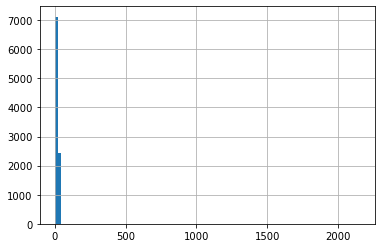

In [50]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
8,11.53,ppt,NaN,11.53 Practical_Salinity_Units
10,16.51,ppt,NaN,16.51 Practical_Salinity_Units
12,1.33,ppth,NaN,1.33 Practical_Salinity_Units
14,17.43,ppt,NaN,17.43 Practical_Salinity_Units
31,12.74,ppt,NaN,12.74 Practical_Salinity_Units
...,...,...,...,...
60545,7.61,ppt,NaN,7.61 Practical_Salinity_Units
60548,9.58,ppt,NaN,9.58 Practical_Salinity_Units
60562,2,ppt,NaN,2.0 Practical_Salinity_Units
60605,.5,ppt,NaN,0.5 Practical_Salinity_Units


###### Nitrogen

-Usable results-
count     56.000000
mean      27.876660
std       75.386966
min        0.160000
25%        0.600000
50%        0.705000
75%        1.225000
max      314.000000
dtype: float64
Unusable results: 0
Usable results with inferred units: 0
Results outside threshold (0.0 to 480.1984578860486): 0


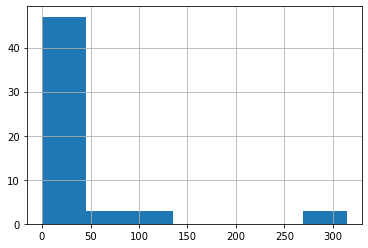

In [52]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
9927,51.899999999999999,mg/kg,NaN,51.90000000000001 milligram / liter
9928,51.899999999999999,mg/kg,NaN,51.90000000000001 milligram / liter
9929,51.899999999999999,mg/kg,NaN,51.90000000000001 milligram / liter
10214,0.53125,mg/l,NaN,0.53125 milligram / liter
10215,0.53125,mg/l,NaN,0.53125 milligram / liter
11107,131,mg/kg,NaN,131.00000000000003 milligram / liter
11108,131,mg/kg,NaN,131.00000000000003 milligram / liter
11109,131,mg/kg,NaN,131.00000000000003 milligram / liter
12060,314,mg/kg,NaN,314.00000000000006 milligram / liter
12061,314,mg/kg,NaN,314.00000000000006 milligram / liter


###### Conductivity

-Usable results-
count     1787.000000
mean     18812.165003
std      15717.583598
min          0.040000
25%        536.650000
50%      20385.000000
75%      31275.550000
max      54886.200000
dtype: float64
Unusable results: 1
Usable results with inferred units: 0
Results outside threshold (0.0 to 113117.66658833897): 0


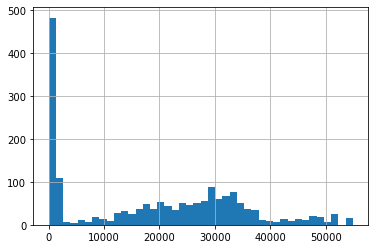

In [54]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True)

Note: No report because too few results

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
4,42,umho/cm,NaN,42.0 microsiemens / centimeter
96,28183.5,umho/cm,NaN,28183.5 microsiemens / centimeter
122,26243.3,umho/cm,NaN,26243.3 microsiemens / centimeter
264,19204.2,umho/cm,NaN,19204.2 microsiemens / centimeter
273,97.6,umho/cm,NaN,97.6 microsiemens / centimeter
...,...,...,...,...
60586,700,umho/cm,NaN,700.0 microsiemens / centimeter
60598,390,umho/cm,NaN,390.0 microsiemens / centimeter
60599,90,umho/cm,NaN,90.0 microsiemens / centimeter
60616,3000,umho/cm,NaN,3000.0 microsiemens / centimeter


###### Chlorophyll a

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'None' UNDEFINED UNIT
  warn("WARNING: " + problem)


-Usable results-
count    1002.000000
mean        0.152335
std         0.388867
min         0.000000
25%         0.002200
50%         0.006000
75%         0.016000
max         1.950000
dtype: float64
Unusable results: 254
Usable results with inferred units: 0
Results outside threshold (0.0 to 2.485539632832204): 0


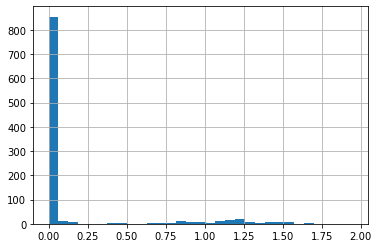

In [56]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
120,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
131,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
146,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
247,2.6,mg/m3,NaN,0.0026000000000000007 milligram / liter
306,1.6,mg/m3,NaN,0.0016000000000000005 milligram / liter
...,...,...,...,...
60478,1.1,mg/m3,NaN,0.0011000000000000003 milligram / liter
60490,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
60516,3.3,mg/m3,NaN,0.0033000000000000004 milligram / liter
60519,3.3,mg/m3,NaN,0.0033000000000000004 milligram / liter


###### Organic Carbon

-Usable results-
count      1158.000000
mean       1338.363532
std        8869.804354
min           0.000000
25%           2.433750
50%           4.700000
75%           8.800000
max      160000.000000
dtype: float64
Unusable results: 114
Usable results with inferred units: 0
Results outside threshold (0.0 to 54557.18965673587): 4


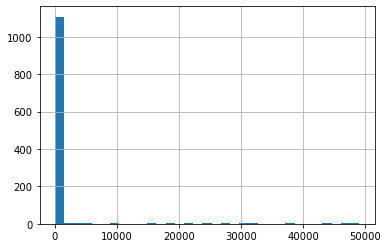

In [58]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
303,NaN,mg/l,ResultMeasureValue: missing (NaN) result,NaN
304,NaN,mg/l,ResultMeasureValue: missing (NaN) result,NaN
449,2.8,mg/l,NaN,2.8 milligram / liter
495,1.1,mg/l,NaN,1.1 milligram / liter
552,2.1,mg/l,NaN,2.1 milligram / liter
...,...,...,...,...
60407,5.4,mg/l,NaN,5.4 milligram / liter
60414,108.2,mg/l,NaN,108.2 milligram / liter
60449,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
60465,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Turbidity

-Usable results-
count     4614.000000
mean        13.403319
std        218.066783
min          0.000000
25%          1.900000
50%          3.000000
75%          5.180000
max      11985.702300
dtype: float64
Unusable results: 33
Usable results with inferred units: 0
Results outside threshold (0.0 to 1321.8040146905444): 4


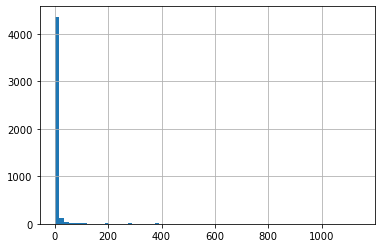

In [60]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True)

In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
81,0.13,NTU,NaN,0.13 Nephelometric_Turbidity_Units
93,6.9,NTU,NaN,6.9 Nephelometric_Turbidity_Units
103,0.10,NTU,NaN,0.1 Nephelometric_Turbidity_Units
140,14,NTU,NaN,14.0 Nephelometric_Turbidity_Units
162,10,JTU,NaN,190.2023 Nephelometric_Turbidity_Units
...,...,...,...,...
60604,15,NTU,NaN,15.0 Nephelometric_Turbidity_Units
60606,2.2,NTU,NaN,2.2 Nephelometric_Turbidity_Units
60612,8,NTU,NaN,8.0 Nephelometric_Turbidity_Units
60620,11,NTU,NaN,11.0 Nephelometric_Turbidity_Units


###### Sediment

In [62]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False)

In [63]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


###### Phosphorus

In [64]:
# Phosphorus
# Note: must be merged w/ activities (package runs query by site if not already merged)
df = harmonize.harmonize_generic(df, 'Phosphorus')

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Filterable_Phosphorus" column for Filterable, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Total_Recoverable_Phosphorus" column for Total Recoverable, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Unfiltered_Phosphorus" column for Unfiltered, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Non-Filterable_(Particle)_Phosphorus" column for Non-Filterable (Particle), may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "__Phosphorus" column for  , may be error
 

Note the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
1235,0.002,mg/l,NaN,0.002 milligram / liter
1498,0.019,mg/l,NaN,0.019 milligram / liter
6334,0.003,mg/l,NaN,0.003 milligram / liter
7993,0.019,mg/l,NaN,0.019 milligram / liter
23746,0.017,mg/l,NaN,0.017 milligram / liter
23981,0.002,mg/l,NaN,0.002 milligram / liter
26066,0.021,mg/l,NaN,0.021 milligram / liter
26889,0.003,mg/l,NaN,0.003 milligram / liter
27158,0.002,mg/l,NaN,0.002 milligram / liter
27536,0.020,mg/l,NaN,0.02 milligram / liter


In [66]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TP_Phosphorus
145,.058,mg/l,NaN,0.057999999999999996 milligram / liter
246,.044,mg/l,NaN,0.044000000000000004 milligram / liter
285,.13,mg/l,NaN,0.13 milligram / liter
323,.085,mg/l,NaN,0.085 milligram / liter
325,.035,mg/l,NaN,0.035 milligram / liter
...,...,...,...,...
60493,.039,mg/l,NaN,0.039 milligram / liter
60512,0.009,mg/l,NaN,0.009000000000000001 milligram / liter
60526,0.008,mg/l,NaN,0.008 milligram / liter
60543,0.016,mg/l,NaN,0.016 milligram / liter


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

-Usable results-
count     6459.000000
mean       117.995975
std        504.149166
min          0.000000
25%          3.000000
50%         13.000000
75%         63.500000
max      19900.000000
dtype: float64
Unusable results: 1485
Usable results with inferred units: 0
Results outside threshold (0.0 to 3142.890972139957): 23


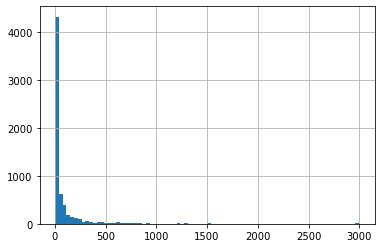

In [67]:
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True)

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
6,9,cfu/100ml,NaN,9.0 Colony_Forming_Units / milliliter
7,9,cfu/100ml,NaN,9.0 Colony_Forming_Units / milliliter
24,1,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter
25,1,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter
28,3,cfu/100ml,NaN,3.0 Colony_Forming_Units / milliliter
...,...,...,...,...
60076,60,cfu/100ml,NaN,60.0 Colony_Forming_Units / milliliter
60100,145,cfu/100ml,NaN,145.0 Colony_Forming_Units / milliliter
60137,317,cfu/100ml,NaN,317.0 Colony_Forming_Units / milliliter
60160,245,cfu/100ml,NaN,245.0 Colony_Forming_Units / milliliter


###### Escherichia coli

-Usable results-
count     292.000000
mean      282.529110
std       609.050015
min         1.000000
25%        67.250000
50%       122.000000
75%       241.000000
max      6867.000000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 3936.829200910381): 2


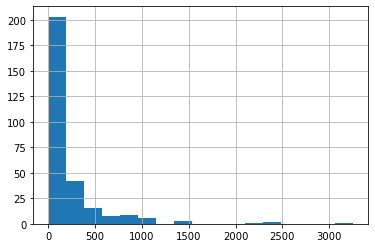

In [69]:
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True)

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
100,75,MPN/100ml,NaN,75.0 Colony_Forming_Units / milliliter
523,63,MPN/100ml,NaN,63.0 Colony_Forming_Units / milliliter
1483,190,MPN/100ml,NaN,190.0 Colony_Forming_Units / milliliter
2031,1000,MPN,NaN,1000.0 Colony_Forming_Units / milliliter
2213,1000,MPN,NaN,1000.0 Colony_Forming_Units / milliliter
...,...,...,...,...
58038,50,MPN/100ml,NaN,50.0 Colony_Forming_Units / milliliter
58998,31,MPN/100ml,NaN,31.0 Colony_Forming_Units / milliliter
59922,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
60158,6,cfu/100ml,NaN,6.0 Colony_Forming_Units / milliliter


### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

In [71]:
from harmonize_wq import convert

There are not enough conductivity results to demonstrate this fully in pensacola Bay. We'll mainly just explore Salinity results.

In [72]:
#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(harmonize_WQP.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [73]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 9547 
Mean: 19.04553336126542 PSU


In [74]:
# Identify extreme outliers
[x for x in lst if x >3200]

[37782.0]

In [75]:
# Look at important fields for max value
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
salinity_series = df['Salinity'][df['Salinity'].notna()]
x = max(salinity_series)
idx = df[df['Salinity']==x].index
df[cols][df['Salinity']==x]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
12707,37782,ppth,NaN,37782.0 Practical_Salinity_Units


In [76]:
# Look at important fields for second max value
x2 = max(salinity_series.drop(index=idx))
df[cols][df['Salinity']==x2]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
11518,2150,ppth,NaN,2150.0 Practical_Salinity_Units


Nothing jumps out as problematic for either value

In [77]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

4           42.0 microsiemens / centimeter
96       28183.5 microsiemens / centimeter
122      26243.3 microsiemens / centimeter
264      19204.2 microsiemens / centimeter
273         97.6 microsiemens / centimeter
                       ...                
60586      700.0 microsiemens / centimeter
60598      390.0 microsiemens / centimeter
60599       90.0 microsiemens / centimeter
60616     3000.0 microsiemens / centimeter
60622       55.0 microsiemens / centimeter
Name: Conductivity, Length: 1787, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm. The value we have is well within that.

In [78]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
4,42,umho/cm,NaN,NaN,42.0 microsiemens / centimeter
96,28183.5,umho/cm,NaN,NaN,28183.5 microsiemens / centimeter
122,26243.3,umho/cm,NaN,NaN,26243.3 microsiemens / centimeter
264,19204.2,umho/cm,NaN,NaN,19204.2 microsiemens / centimeter
273,97.6,umho/cm,NaN,NaN,97.6 microsiemens / centimeter
...,...,...,...,...,...
60586,700,umho/cm,NaN,NaN,700.0 microsiemens / centimeter
60598,390,umho/cm,NaN,NaN,390.0 microsiemens / centimeter
60599,90,umho/cm,NaN,NaN,90.0 microsiemens / centimeter
60616,3000,umho/cm,NaN,NaN,3000.0 microsiemens / centimeter


In [79]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

4         0.027 dimensionless
96       17.341 dimensionless
122      16.035 dimensionless
264      11.401 dimensionless
273       0.051 dimensionless
                 ...         
60586     0.341 dimensionless
60598     0.188 dimensionless
60599     0.047 dimensionless
60616     1.559 dimensionless
60622     0.032 dimensionless
Name: Salinity, Length: 1787, dtype: object

0.083 is close to expected PSU

### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [80]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
0,2013-09-03,09:01:00,EST
1,2013-09-08,10:01:00,EST
2,2013-05-05,15:55:00,EST
3,2013-04-16,08:01:00,EST
4,2013-08-19,11:00:00,CST
...,...,...,...
60623,1980-12-10,10:35:00,CST
60624,1980-02-20,12:00:00,CST
60625,1980-01-23,10:55:00,CST
60626,1980-08-06,10:00:00,CST


In [81]:
# Note the input columns are dropped (rename the result to preserve these columns)
df = clean.datetime(df)
df[['StartDate', 'Activity_datetime']]

,StartDate,Activity_datetime
0,2013-09-03,2013-09-03 14:01:00+00:00
1,2013-09-08,2013-09-08 15:01:00+00:00
2,2013-05-05,2013-05-05 20:55:00+00:00
3,2013-04-16,2013-04-16 13:01:00+00:00
4,2013-08-19,2013-08-19 17:00:00+00:00
...,...,...
60623,1980-12-10,1980-12-10 16:35:00+00:00
60624,1980-02-20,1980-02-20 18:00:00+00:00
60625,1980-01-23,1980-01-23 16:55:00+00:00
60626,1980-08-06,1980-08-06 16:00:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

### Depth

In [82]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

193       7.0
1416      7.0
16705    16.0
16809    16.0
17825     1.0
34155    35.0
Name: ResultDepthHeightMeasure/MeasureValue, dtype: float64

Data are often lacking sample depth metadata, even this small number including depth is good

### Characteristic to Column (long to wide format)

In [83]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_Nitrogen,QA_DO,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Unfiltered_Phosphorus,QA_Fecal_Coliform,QA_Conductivity,QA_E_coli,QA_Salinity
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1533025F1,21FLPNS_WQX-33010H24,STORET-308200310,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1534026F1,21FLBFA_WQX-33020M31,STORET-272693106,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1502139F1-19151,21FLBFA_WQX-33010092,STORET-747267008,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1497856F1,21FLPNS_WQX-330100A7,STORET-308209380,NaN,NaN,NaN,pH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-195719_1074008_173,21AWIC-7290,STORET-290894183,1074008.0,NaN,NaN,Conductivity,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60623,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113232_629452_173,21AWIC-942,STORET-175988174,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60624,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113212_629390_173,21AWIC-942,STORET-175987603,NaN,NaN,NaN,pH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60625,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113210_629386_173,21AWIC-942,STORET-175987555,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60626,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-113224_629429_173,21AWIC-942,STORET-175987899,NaN,NaN,NaN,Turbidity,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

15 new columns


In [85]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

2034 fewer rows


In [86]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [87]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [88]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier',
       'ResultIdentifier', 'ProviderName', 'Secchi', 'Temperature', 'DO', 'pH',
       'Salinity', 'Nitrogen', 'Speciation', 'Conductivity', 'Chlorophyll',
       'Carbon', 'Turbidity', 'Sediment', 'Phosphorus', 'TP_Phosphorus',
       'TDP_Phosphorus', 'Other_Phosphorus', 'Unfiltered_Phosphorus',
       'Fecal_Coliform', 'E_coli', 'StartDate', 'Activity_datetime', 'Depth',
       'QA_pH', 'QA_Carbon', 'QA_Chlorophyll', 'QA_Temperature',
       'QA_Turbidity', 'QA_Secchi', 'QA_Nitrogen', 'QA_DO', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Unfiltered_Phosphorus',
       'QA_Fecal_Coliform', 'QA_Conductivity', 'QA_E_coli', 'QA_Salinity'],
      dtype='object')

In [89]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,ProviderName,Secchi,Temperature,DO,pH,...,QA_Nitrogen,QA_DO,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Unfiltered_Phosphorus,QA_Fecal_Coliform,QA_Conductivity,QA_E_coli,QA_Salinity
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1533025F1,21FLPNS_WQX-33010H24,STORET-308200310,STORET,NaN,NaN,5.07 milligram / liter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1534026F1,21FLBFA_WQX-33020M31,STORET-272693106,STORET,NaN,29.56 degree_Celsius,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1502139F1-19151,21FLBFA_WQX-33010092,STORET-747267008,STORET,NaN,NaN,7.48 milligram / liter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1497856F1,21FLPNS_WQX-330100A7,STORET-308209380,STORET,NaN,NaN,NaN,6.93 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-195719_1074008_173,21AWIC-7290,STORET-290894183,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Carbon',
 'QA_Temperature',
 'QA_Turbidity',
 'QA_Secchi',
 'QA_Nitrogen',
 'QA_DO',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Unfiltered_Phosphorus',
 'QA_Fecal_Coliform',
 'QA_Conductivity',
 'QA_E_coli',
 'QA_Salinity']

In [91]:
# Join to stations to quickly aggegate/map
merge_cols = ['MonitoringLocationIdentifier', 'OrganizationIdentifier']
gdf_cols = ['geometry', 'QA_flag']
results_df = wrangle.merge_tables(main_df, stations_clipped, gdf_cols, merge_cols)

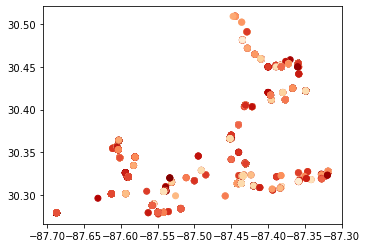

In [92]:
# Map average temperature
results_gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')
results_gdf.plot(column='Temperature', cmap='OrRd')